# Sonar Visualization Playground

Quick-start notebook to run the 2D sonar simulator, view wavefields inline, and export GIFs for report/presentation assets.

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams['animation.embed_limit'] = 50  # MB, pick your size

from IPython.display import HTML, Image

from setup_sonar_model import setup_sonar_model, print_model_info
from simpleLeapFrog import LeapfrogSolver
from sonar_viz import plot_pressure_xz_at
from create_wave_animation import create_wave_animation


## Run a baseline simulation
Configure a moderate grid and stable timestep (fraction of CFL). Adjust `Nx/Nz` or `t_extra` for larger domains or longer runs.

In [2]:
# def run_simulation(Nx=201, Nz=51, Lx=5625, Lz=937.5, f0=20, t_extra=0.2, dt_scale=0.5):
def run_simulation(Nx=200, Nz=50, Lx=2000, Lz=500, f0=20, t_extra=0.2, dt_scale=0.5):
# def run_simulation(dt_scale=0.5):
    """Run sonar simulation and return state history"""
    model = setup_sonar_model(Nx=Nx, Nz=Nz, Lx=Lx, Lz=Lz, f0=f0, t_extra=t_extra, source_position='center')
    # model = setup_sonar_model(t_extra=3)
    dt = dt_scale * model['max_dt_FE']
    num_steps = int(np.ceil((model['t_stop'] - model['t_start']) / dt))
    print_model_info(model, verbose=False)
    print(f"Using dt = {dt:.3e} s with {num_steps} steps")
    X, t = LeapfrogSolver(model['eval_f'], model['x_start'], model['p'], model['eval_u'], num_steps, dt, visualize=False, verbose=False)
    return {"model": model, "X": X, "t": t}

# Run a default scenario
sim = run_simulation()


SONAR MODEL CONFIGURATION

Grid: 200 × 50 = 10,000 cells
Domain: 2000m × 500m
Spacing: dx = 10.0503m, dz = 10.2041m

Acoustic Properties:
  Sound speed: c = 1500.0 m/s
  Frequency: f₀ = 20 Hz
  Wavelength: λ = 75.00m
  Resolution: 7.5 points per wavelength
  Domain coverage: 26.7λ × 6.7λ

Source Position:
  Grid indices: (100, 25)
  Physical: x = 1005.0m, z = 255.1m

Hydrophones: 5 receivers
  Type: Horizontal array at z = 255.1m
    H1: x = 331.7m
    H2: x = 663.3m
    H3: x = 995.0m
    H4: x = 1326.6m
    H5: x = 1658.3m

Time Integration:
  Time span: 0.000s to 1.533s (1533.3ms)
  Max stable dt (CFL): 2368.87 μs

State Vector: 20,000 DOFs
Using dt = 1.184e-03 s with 1295 steps
Running Leapfrog solver (stable for wave equations)...


## Single-frame snapshot
Inspect the pressure field at a chosen time (ms).

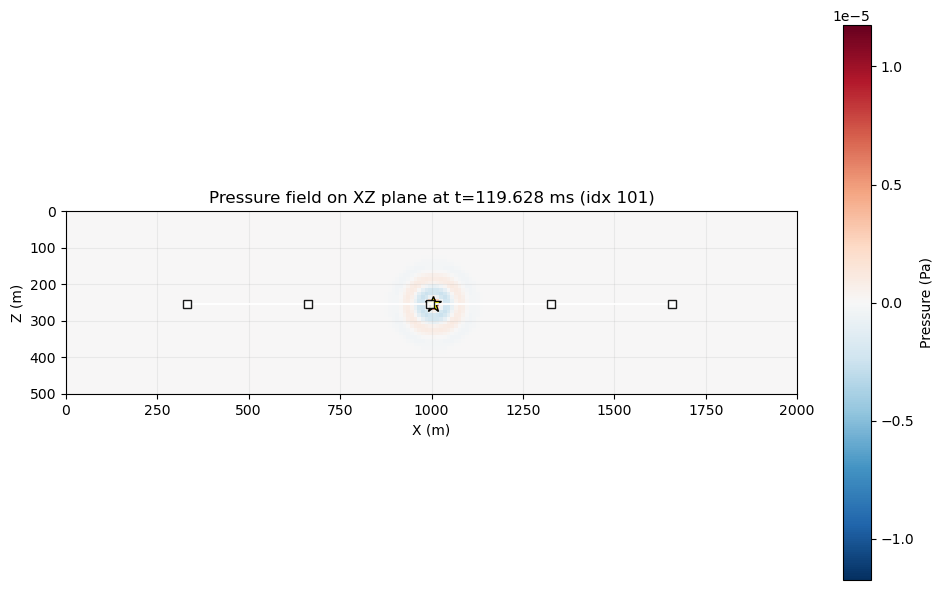

In [3]:
# Plot near the first surface reflection; tweak time_s as needed
_ = plot_pressure_xz_at(sim['model']['p'], sim['X'], sim['t'], time_s=0.12)


## Inline animation (HTML)
Lightweight animation for notebook viewing. Use `frame_skip` to trade fidelity for speed.

In [4]:
def make_inline_animation(sim, frame_skip=1, interval=80, max_frames=300):
    p = sim['model']['p']
    X = sim['X']
    t = sim['t']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    dx, dz = p['dx'], p['dz']
    pressure = X[:N, :].reshape(Nx, Nz, -1)
    total_frames = pressure.shape[2]

    v_abs = np.max(np.abs(pressure)) if pressure.size else 1.0
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(
        pressure[:, :, 0].T,
        extent=[0, p['Lx'], p['Lz'], 0],
        cmap='RdBu_r',
        vmin=-v_abs,
        vmax=v_abs,
        aspect='equal'
    )

    # Overlay source and hydrophones once (static markers)
    sx = p['sonar_ix'] * dx
    sz = p['sonar_iz'] * dz
    ax.plot([sx], [sz], marker='*', color='yellow', markersize=10, markeredgecolor='k', label='Source')
    hp = p.get('hydrophones', {})
    if hp.get('n_phones', 0) > 0:
        if 'z_pos' in hp and 'x_indices' in hp:
            zpos = hp['z_pos'] * dz
            for xi in hp['x_indices']:
                ax.plot(xi * dx, zpos, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
        elif 'x_pos' in hp and 'z_indices' in hp:
            xpos = hp['x_pos'] * dx
            for zi in hp['z_indices']:
                ax.plot(xpos, zi * dz, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title('Wavefield animation')
    plt.close(fig)  # prevent duplicate static display

    def animate(i):
        frame = min(i * frame_skip, total_frames - 1)
        im.set_array(pressure[:, :, frame].T)
        ax.set_title(f't = {t[frame]*1000:.1f} ms')
        return [im]

    max_frames = min(max_frames, (total_frames + frame_skip - 1) // frame_skip)
    anim = animation.FuncAnimation(fig, animate, frames=max_frames, interval=interval, blit=True)
    return HTML(anim.to_jshtml())

# Display inline animation
# make_inline_animation(sim, frame_skip=2, interval=60, max_frames=1200)

# make_inline_animation(sim, frame_skip=2, interval=60, max_frames=300)


## Fast GIF writer (imageio)
Bypass Matplotlib animation and write frames directly. Adjust `frame_skip`/`max_frames`/`fps` to trade speed vs. smoothness.

/tmp/ipykernel_10710/218831407.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


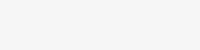

In [5]:
import imageio.v2 as imageio
import matplotlib.cm as cm

def save_gif_fast(sim, gif_path, frame_skip=4, max_frames=300, fps=12, cmap_name="RdBu_r"):
    p = sim['model']['p']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    pressure = sim['X'][:N, :].reshape(Nx, Nz, -1)
    v_abs = float(np.max(np.abs(pressure))) if pressure.size else 1.0
    cmap = cm.get_cmap(cmap_name)

    frames = []
    # Limit frames to keep runtime reasonable
    max_idx = min(pressure.shape[2], frame_skip * max_frames)
    for i in range(0, max_idx, frame_skip):
        frame = pressure[:, :, i].T
        norm = (frame + v_abs) / (2 * v_abs + 1e-12)  # map [-v_abs, v_abs] -> [0,1]
        rgba = (cmap(np.clip(norm, 0, 1)) * 255).astype(np.uint8)
        frames.append(rgba)

    imageio.mimsave(gif_path, frames, fps=fps)
    return gif_path

# Example fast export
os.makedirs('report/figs', exist_ok=True)
fast_gif_path = 'report/figs/sonar_wavefield_fast.gif'
save_gif_fast(sim, fast_gif_path, frame_skip=4, max_frames=400, fps=12)
Image(filename=fast_gif_path)


## Hydrophone traces
Plot pressure at the configured hydrophones to accompany animations.

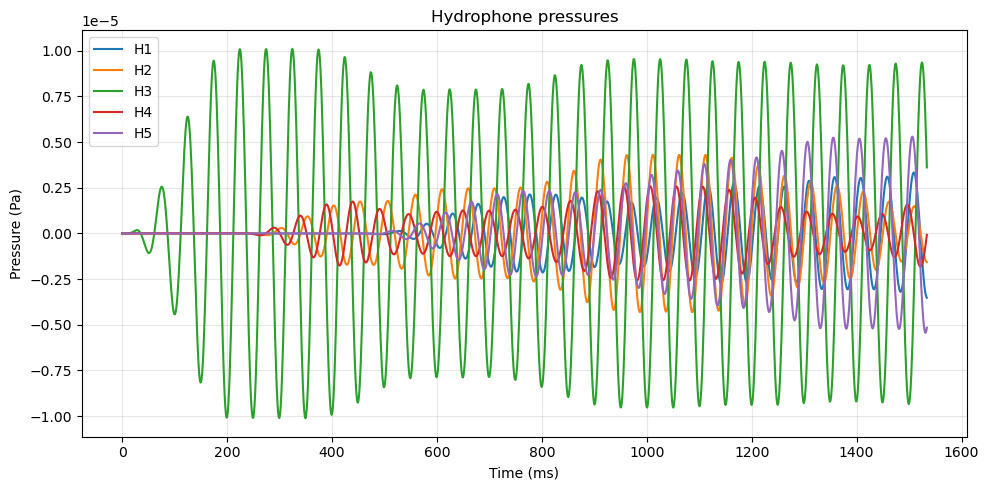

In [6]:
from eval_g_Sonar import eval_g_Sonar

def plot_hydrophones(sim, stride=1):
    p = sim['model']['p']
    t_full = sim['t']
    idx = np.arange(0, len(t_full), stride)
    t = t_full[idx]

    traces = []
    for i in idx:
        x_col = sim['X'][:, i].reshape(-1, 1)
        traces.append(eval_g_Sonar(x_col, p).reshape(-1))
    traces = np.stack(traces)

    plt.figure(figsize=(10, 5))
    for k in range(traces.shape[1]):
        plt.plot(t * 1000, traces[:, k], label=f'H{k+1}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Pressure (Pa)')
    plt.title('Hydrophone pressures')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

plot_hydrophones(sim, stride=1)


## (Optional) Notes
- Increase `Nx/Nz` or `t_extra` for higher-fidelity visuals; adjust `frame_skip` to keep animations responsive.
- Swap in `getParam_Absorb.py` (sponge/PML) inside `setup_sonar_model` if you prefer fewer boundary reflections for visuals.
- For MOR comparisons, run a reduced-order model separately and feed both `X` arrays into a modified animation that overlays or plots residuals.

## Wavefield + Hydrophone Waterfall
Dual-panel animation: wave propagation with source/hydrophone markers and a synchronized hydrophone waterfall with a time cursor.

In [7]:
from eval_g_Sonar import eval_g_Sonar

def make_wave_plus_waterfall(sim, frame_skip=2, interval=60, max_frames=400):
    p, X, t = sim['model']['p'], sim['X'], sim['t']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    dx, dz = p['dx'], p['dz']
    pressure = X[:N, :].reshape(Nx, Nz, -1)
    total_frames = pressure.shape[2]

    # Precompute hydrophone traces
    traces = []
    for i in range(total_frames):
        traces.append(eval_g_Sonar(X[:, i].reshape(-1, 1), p).reshape(-1))
    traces = np.stack(traces)
    H = traces.shape[1]
    t_ms = t * 1000

    # Wavefield panel
    v_abs = np.max(np.abs(pressure)) if pressure.size else 1.0
    fig, (ax_w, ax_h) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]})
    im_w = ax_w.imshow(pressure[:, :, 0].T, extent=[0, p['Lx'], p['Lz'], 0],
                       cmap='RdBu_r', vmin=-v_abs, vmax=v_abs, aspect='equal')
    sx, sz = p['sonar_ix'] * dx, p['sonar_iz'] * dz
    ax_w.plot([sx], [sz], '*', color='yellow', markersize=10, markeredgecolor='k', label='Source')
    hp = p.get('hydrophones', {})
    if hp.get('n_phones', 0) > 0:
        if 'z_pos' in hp and 'x_indices' in hp:
            zpos = hp['z_pos'] * dz
            for xi in hp['x_indices']:
                ax_w.plot(xi * dx, zpos, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
        elif 'x_pos' in hp and 'z_indices' in hp:
            xpos = hp['x_pos'] * dx
            for zi in hp['z_indices']:
                ax_w.plot(xpos, zi * dz, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
    ax_w.set_xlabel('X (m)'); ax_w.set_ylabel('Z (m)')

    # Waterfall panel (time vs hydrophone index)
    im_h = ax_h.imshow(traces.T, aspect='auto',
                       extent=[t_ms[0], t_ms[-1], H + 0.5, 0.5],
                       cmap='viridis')
    cursor = ax_h.axvline(t_ms[0], color='red', linestyle='--', linewidth=1.5)
    ax_h.set_xlabel('Time (ms)'); ax_h.set_ylabel('Hydrophone #')
    plt.close(fig)  # prevent duplicate static display

    def animate(i):
        frame = min(i * frame_skip, total_frames - 1)
        im_w.set_array(pressure[:, :, frame].T)
        ax_w.set_title(f't = {t_ms[frame]:.1f} ms')
        cursor.set_xdata([t_ms[frame], t_ms[frame]])
        return [im_w, cursor]

    nframes = min(max_frames, (total_frames + frame_skip - 1) // frame_skip)
    anim = animation.FuncAnimation(fig, animate, frames=nframes, interval=interval, blit=True)
    return HTML(anim.to_jshtml())

# Example
# make_wave_plus_waterfall(sim, frame_skip=2, interval=60, max_frames=400)


## Wavefield + Hydrophone Lines
Dual-panel animation with stacked line plots of hydrophone pressures and a moving time cursor, synced to the wavefield.

In [ ]:
# Line-plot variant for hydrophones
from eval_g_Sonar import eval_g_Sonar

def make_wave_plus_lines(sim, frame_skip=2, interval=60, max_frames=400, stride=1):
    p, X, t = sim['model']['p'], sim['X'], sim['t']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    dx, dz = p['dx'], p['dz']
    pressure = X[:N, :].reshape(Nx, Nz, -1)
    total_frames = pressure.shape[2]

    # Subsample frames for plotting if desired
    idx = list(range(0, total_frames, stride))
    if idx[-1] != total_frames - 1:
        idx.append(total_frames - 1)

    # Precompute hydrophone traces on idx frames
    traces = []
    for i in idx:
        traces.append(eval_g_Sonar(X[:, i].reshape(-1, 1), p).reshape(-1))
    traces = np.stack(traces)
    H = traces.shape[1]
    t_ms = t[idx] * 1000

    # Wavefield panel
    v_abs = np.max(np.abs(pressure)) if pressure.size else 1.0
    fig, (ax_w, ax_h) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]})
    im_w = ax_w.imshow(pressure[:, :, 0].T, extent=[0, p['Lx'], p['Lz'], 0],
                       cmap='RdBu_r', vmin=-v_abs, vmax=v_abs, aspect='equal')
    sx, sz = p['sonar_ix'] * dx, p['sonar_iz'] * dz
    ax_w.plot([sx], [sz], '*', color='yellow', markersize=10, markeredgecolor='k', label='Source')
    hp = p.get('hydrophones', {})
    if hp.get('n_phones', 0) > 0:
        if 'z_pos' in hp and 'x_indices' in hp:
            zpos = hp['z_pos'] * dz
            for xi in hp['x_indices']:
                ax_w.plot(xi * dx, zpos, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
        elif 'x_pos' in hp and 'z_indices' in hp:
            xpos = hp['x_pos'] * dx
            for zi in hp['z_indices']:
                ax_w.plot(xpos, zi * dz, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
    ax_w.set_xlabel('X (m)'); ax_w.set_ylabel('Z (m)')

    # Line plots panel
    colors = plt.cm.tab10(np.linspace(0, 1, H))
    for k in range(H):
        ax_h.plot(t_ms, traces[:, k], color=colors[k], label=f'H{k+1}')
    cursor = ax_h.axvline(t_ms[0], color='red', linestyle='--', linewidth=1.5)
    ax_h.set_xlabel('Time (ms)'); ax_h.set_ylabel('Pressure (Pa)')
    ax_h.grid(True, alpha=0.3)
    ax_h.legend()
    plt.close(fig)  # prevent duplicate static display

    def animate(i):
        frame_idx = min(i * frame_skip, len(idx) - 1)
        frame = idx[frame_idx]
        im_w.set_array(pressure[:, :, frame].T)
        ax_w.set_title(f't = {t_ms[frame_idx]:.1f} ms')
        cursor.set_xdata([t_ms[frame_idx], t_ms[frame_idx]])
        return [im_w, cursor]

    nframes = min(max_frames, (len(idx) + frame_skip - 1) // frame_skip)
    anim = animation.FuncAnimation(fig, animate, frames=nframes, interval=interval, blit=True)
    return HTML(anim.to_jshtml())

# Example
# make_wave_plus_lines(sim, frame_skip=2, interval=60, max_frames=400, stride=1)
make_wave_plus_lines(sim, frame_skip=10, interval=60, max_frames=300, stride=1)
